In [ ]:
!unzip /content/Cirrhosis_T2_2D.zip -d /content/Cirrhosis_T2_2D


Streaming output truncated to the last 5000 lines.
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/21.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/22.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/23.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/24.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/25.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/26.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/27.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/28.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/29.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/30.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/31.png  
  inflating: /content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train/354/masks/32.png  
 

In [ ]:
import os
print(os.listdir('/content/Cirrhosis_T2_2D/Cirrhosis_T2_2D'))

['test', 'valid', 'train']


Found 5428 images and 5428 masks.
Found 674 images and 674 masks.
Found 664 images and 664 masks.
Train dataset size: 5428
Valid dataset size: 674
Test dataset size: 664
Training the model...
Epoch 1: 
  Train Loss: 0.5428, Dice: 0.3968, Recall: 0.4913, Precision: 0.5307
  Validation Loss: 0.4563, Dice: 0.5182, Recall: 0.6005, Precision: 0.5233
Epoch 1 duration: 542.67 seconds, Avg Iteration: 0.40 seconds
Epoch 2: 
  Train Loss: 0.4686, Dice: 0.5049, Recall: 0.6099, Precision: 0.5043
  Validation Loss: 0.4361, Dice: 0.5437, Recall: 0.5522, Precision: 0.6040
Epoch 2 duration: 525.21 seconds, Avg Iteration: 0.39 seconds
Epoch 3: 
  Train Loss: 0.4533, Dice: 0.5235, Recall: 0.6319, Precision: 0.5194
  Validation Loss: 0.4212, Dice: 0.5672, Recall: 0.7359, Precision: 0.5226
Epoch 3 duration: 524.55 seconds, Avg Iteration: 0.39 seconds
Epoch 4: 
  Train Loss: 0.4460, Dice: 0.5317, Recall: 0.6435, Precision: 0.5252
  Validation Loss: 0.4377, Dice: 0.5424, Recall: 0.5113, Precision: 0.6583
Ep

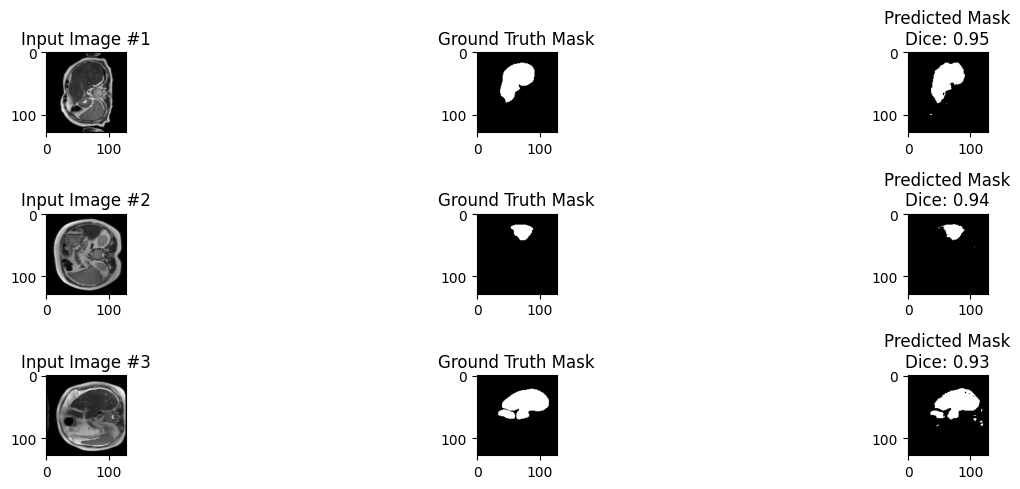

Epochs: 17
Train Loss Length: 17
Validation Loss Length: 17
Test Loss Length: 1


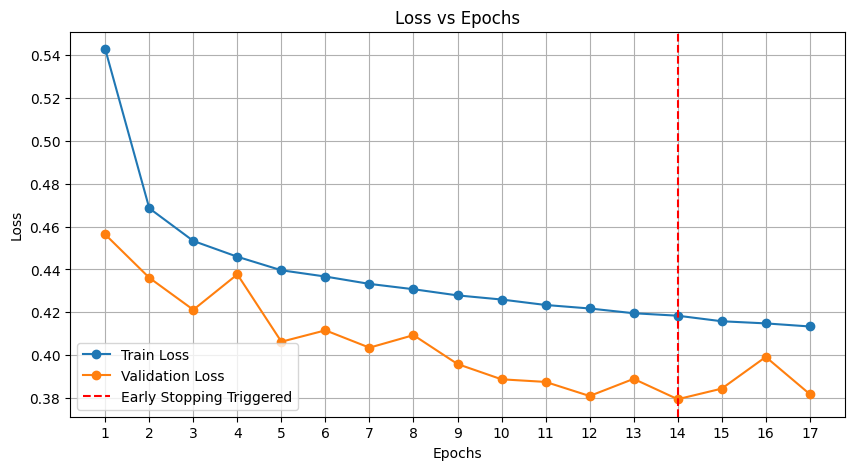

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.amp import GradScaler, autocast
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# Dataset Class
class LiverDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        # Collect image-mask pairs
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                image_dir = os.path.join(subfolder_path, 'images')
                mask_dir = os.path.join(subfolder_path, 'masks')

                # Collect files
                for filename in os.listdir(image_dir):
                    if filename.endswith(".png"):
                        image_path = os.path.join(image_dir, filename)
                        mask_path = os.path.join(mask_dir, filename)
                        self.image_paths.append(image_path)
                        self.mask_paths.append(mask_path)

        print(f"Found {len(self.image_paths)} images and {len(self.mask_paths)} masks.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Ensure binary masks

        return image, mask   #, liver_size

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Directories for train, validation, and test sets
train_dir = '/content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/train'
valid_dir = '/content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/valid'
test_dir = '/content/Cirrhosis_T2_2D/Cirrhosis_T2_2D/test'

# Initialize datasets
train_dataset = LiverDataset(train_dir, transform=transform)
valid_dataset = LiverDataset(valid_dir, transform=transform)
test_dataset = LiverDataset(test_dir, transform=transform)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# DataLoader
"""
Change 1
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
"""
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

#This model retains the essence of UNet but is significantly lighter and faster.
class UNetLite(nn.Module):
    def __init__(self):
        super(UNetLite, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        bottleneck = self.bottleneck(self.pool1(enc1))
        dec1 = self.dec1(torch.cat([self.up1(bottleneck), enc1], dim=1))
        return self.final(dec1)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def dice_coefficient(outputs, targets):
    # Ensure binary masks (threshold outputs at 0.5)
    outputs = (outputs > 0.5).bool()  # Convert to boolean tensor
    targets = targets.bool()          # Ensure targets are boolean

    # Compute Dice coefficient
    intersection = (outputs & targets).sum(dim=(-2, -1)).float()
    union = outputs.sum(dim=(-2, -1)).float() + targets.sum(dim=(-2, -1)).float()

    dice_score = (2.0 * intersection / (union + 1e-7)).mean()
    return dice_score

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5, pos_weight=None):
        """
        Args:
            dice_weight: Weight for Dice Loss.
            bce_weight: Weight for BCEWithLogitsLoss.
            pos_weight: Coefficient for compensating for class imbalance.
        """
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def dice_loss(self, outputs, targets):
        smooth = 1e-6
        outputs = torch.sigmoid(outputs)  # Converting logits to probabilities
        intersection = (outputs * targets).sum(dim=(2, 3))
        union = outputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()  # Dice Loss = 1 - Dice Coefficient

    def forward(self, outputs, targets):
        dice_loss = self.dice_loss(outputs, targets)
        bce_loss = self.bce_loss(outputs, targets)
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss

def recall_score(outputs, targets):
    """
    Calculating Recall for segmentation.
    Args:
        outputs: Predicted values (logits or probabilities).
        targets: True values (binary masks).
    Returns:
        Recall (proportion of correctly predicted positive class pixels).
    """
    smooth = 1e-6
    outputs = (torch.sigmoid(outputs) > 0.5).float()  # Transforming logits into binary predictions
    targets = targets.float()

    true_positives = (outputs * targets).sum(dim=(2, 3))
    false_negatives = ((1 - outputs) * targets).sum(dim=(2, 3))

    recall = (true_positives + smooth) / (true_positives + false_negatives + smooth)
    return recall.mean()

def precision_score(outputs, targets):
    """
    Calculate Precision for segmentation.
    Args:
        outputs: Predicted values (logits or probabilities).
        targets: True values (binary masks).
    Returns:
        Precision (proportion of correctly predicted positive pixels).
    """
    smooth = 1e-6
    outputs = (torch.sigmoid(outputs) > 0.5).float()  # Transforming logits into binary predictions
    targets = targets.float()

    true_positives = (outputs * targets).sum(dim=(2, 3))
    false_positives = (outputs * (1 - targets)).sum(dim=(2, 3))

    precision = (true_positives + smooth) / (true_positives + false_positives + smooth)
    return precision.mean()

# Initialize the model
model = UNetLite()
model.apply(initialize_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dice_weight = 0.7  # Importance of Dice Loss
bce_weight = 0.3   # Importance of ALL Loss

# If the data is unbalanced, set pos_weight
pos_weight = torch.tensor([2.0]).to(device)

# Initialize the combined loss function
criterion = CombinedLoss(dice_weight=dice_weight, bce_weight=bce_weight, pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)
optimizer.zero_grad()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize GradScaler only if using CUDA
if device.type == 'cuda':
    scaler = GradScaler(device_type='cuda')
else:
    scaler = None

best_loss = float('inf')
early_stopping_counter = 0
patience = 3

train_losses = []
valid_losses = []
valid_accuracies = []

num_epochs = 50

print("Training the model...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_epoch_time = time.time()

    epoch_dice_scores = []
    epoch_recall_scores = []
    epoch_precision_scores = []

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        if device.type == 'cuda':
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
        else:
            outputs = model(images)
            loss = criterion(outputs, masks)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        # Compute results
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == masks).sum().item()
        total += masks.numel()

        # Compute metrics
        dice = dice_coefficient(masks, preds)
        recall = recall_score(preds, masks)
        precision = precision_score(preds, masks)

        epoch_dice_scores.append(dice.item())
        epoch_recall_scores.append(recall.item())
        epoch_precision_scores.append(precision.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    avg_dice_score = np.mean(epoch_dice_scores)
    avg_recall_score = np.mean(epoch_recall_scores)
    avg_precision_score = np.mean(epoch_precision_scores)

    print(f"Epoch {epoch+1}: ")
    print(f"  Train Loss: {avg_train_loss:.4f}, Dice: {avg_dice_score:.4f}, Recall: {avg_recall_score:.4f}, Precision: {avg_precision_score:.4f}")


    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        dice_scores = []
        recall_scores = []
        precision_scores = []


        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == masks).sum().item()
            val_total += masks.numel()

            dice = dice_coefficient(masks, preds)
            recall = recall_score(preds, masks)
            precision = precision_score(preds, masks)

            dice_scores.append(dice.item())
            recall_scores.append(recall.item())
            precision_scores.append(precision.item())

    avg_valid_loss = val_running_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    avg_dice_score = np.mean(dice_scores)
    avg_recall_score = np.mean(recall_scores)
    avg_precision_score = np.mean(precision_scores)

    print(f"  Validation Loss: {avg_valid_loss:.4f}, Dice: {avg_dice_score:.4f}, Recall: {avg_recall_score:.4f}, Precision: {avg_precision_score:.4f}")

    # Save best model
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

    # Scheduler step
    scheduler.step(avg_valid_loss)
    torch.cuda.empty_cache()

    end_epoch_time = time.time()
    epoch_duration = end_epoch_time - start_epoch_time
    avg_iteration_time = epoch_duration / len(train_loader)
    print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds, Avg Iteration: {avg_iteration_time:.2f} seconds")


# Test the model
print("---------------------------------------------------------")
print(f"Testing the model...")
model.eval()

test_losses = []
test_dice_scores = []
test_recall_scores = []
test_precision_scores = []


test_images = []  # Store images for visualization
test_masks = []   # Store masks for visualization
test_predictions = []  # Store predictions for visualization
test_dice_scores = []  # For individual Dice scores
avg_test_losses = []   # To store average test loss per epoch
avg_test_accuracies = []  # To store average test accuracy per epoch

with torch.no_grad():
    correct_pixels = 0
    total_pixels = 0
    running_test_loss = 0.0

    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        running_test_loss += loss.item()

        # Compute predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        # Store images, masks, predictions, and compute metrics for each sample
        for i in range(images.size(0)):
            test_images.append(images[i].cpu().numpy())
            test_masks.append(masks[i].cpu().numpy())
            test_predictions.append(preds[i].cpu().numpy())

            # Compute and store Dice scores
            dice = dice_coefficient(masks[i:i+1], preds[i:i+1]).item()
            test_dice_scores.append(dice)

            # Compute other metrics
            recall = recall_score(preds[i:i+1], masks[i:i+1])
            precision = precision_score(preds[i:i+1], masks[i:i+1])

            test_recall_scores.append(recall.item())
            test_precision_scores.append(precision.item())

    # Calculate and store average test loss
    avg_test_loss = running_test_loss / len(test_loader)
    avg_test_losses.append(avg_test_loss)  # Append average test loss per epoch

    avg_test_dice = np.mean(test_dice_scores)
    avg_test_recall = np.mean(test_recall_scores)
    avg_test_precision = np.mean(test_precision_scores)


# Print test results
print(f"Test Loss: {avg_test_loss:.4f}, Dice: {avg_test_dice:.4f}, Recall: {avg_test_recall:.4f}, Precision: {avg_test_precision:.4f}")

# Sort by Dice scores and get the top 3
num_samples_to_visualize = min(len(test_images), 3)
best_indices = sorted(
    range(len(test_dice_scores)),
    key=lambda i: test_dice_scores[i],
    reverse=True
)[:3]
best_indices = [idx for idx in best_indices if idx < len(test_images)]

print(f"Total test images: {len(test_images)}")
print(f"Total test masks: {len(test_masks)}")
print(f"Total test predictions: {len(test_predictions)}")
print(f"Total Dice scores: {len(test_dice_scores)}")

# Visualize the top 3 images with the best Dice scores
plt.figure(figsize=(15, 5))

for rank, idx in enumerate(best_indices):
    image = test_images[idx].squeeze()
    mask = test_masks[idx].squeeze()
    prediction = test_predictions[idx].squeeze()
    dice_score = test_dice_scores[idx]

    # Plot input image
    plt.subplot(3, 3, rank * 3 + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Input Image #{rank+1}")

    # Plot ground truth mask
    plt.subplot(3, 3, rank * 3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot predicted mask with Dice score
    plt.subplot(3, 3, rank * 3 + 3)
    plt.imshow(prediction, cmap='gray')
    plt.title(f"Predicted Mask\nDice: {dice_score:.2f}")

plt.tight_layout()
plt.show()

# Plot Loss
# Ensure epochs align with train_losses
epochs = range(1, len(train_losses) + 1)

# Debug lengths
print(f"Epochs: {len(epochs)}")
print(f"Train Loss Length: {len(train_losses)}")
print(f"Validation Loss Length: {len(valid_losses)}")
print(f"Test Loss Length: {len(avg_test_losses)}")

# Ensure lengths are aligned
if len(avg_test_losses) < len(train_losses):
    avg_test_losses += [np.nan] * (len(train_losses) - len(avg_test_losses))

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Validation Loss', marker='o')

# Mark the epoch where early stopping was triggered
early_stop_epoch = len(epochs) - early_stopping_counter  # Calculate the epoch
plt.axvline(x=early_stop_epoch, color='red', linestyle='--', label='Early Stopping Triggered')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(epochs) + 1))  # Ensure integer tick labels
plt.legend()
plt.grid()
plt.show()
